# MitoNet: Ki-67 Expression Classifier for H&E Stained Images
This notebook evaluates MitoNet - a nuclei classifier for predicting Ki-67 expression from H&E stains

## Environment Setup

In [1]:
# Uncomment if needed
# !pip3 install torch torchvision torchaudio numpy matplotlib seaborn scikit-learn pillow tqdm

## Library Imports

In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm
import torch.nn as nn

## Data Preparation and Preprocessing

In [4]:
class AdaptivePatchDataset(Dataset):
    def __init__(self, data_dir, transform=None, max_size=None):
        self.data_dir = data_dir
        self.transform = transform
        self.max_size = max_size
        self.samples = []
        for label, subdir in enumerate(['negative', 'positive']):
            dir_path = os.path.join(data_dir, subdir)
            for img_name in os.listdir(dir_path):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(dir_path, img_name), label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.max_size:
            image = transforms.Resize((self.max_size, self.max_size))(image)
        if self.transform:
            image = self.transform(image)
        return image, label
def get_transform(normalize=True, augment=False):
    transform_list = []
    if augment:
        transform_list.extend([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(10),
        ])
    transform_list.append(transforms.ToTensor())
    if normalize:
        transform_list.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )
    return transforms.Compose(transform_list)
def get_data_loader(data_dir, batch_size=32, transform=None, max_size=None, num_workers=0):
    if transform is None:
        transform = get_transform()
    dataset = AdaptivePatchDataset(data_dir, transform, max_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Data Exploration: Sample Visualization

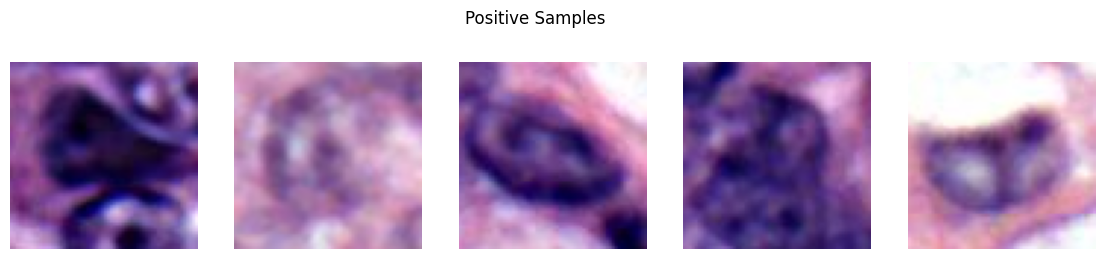

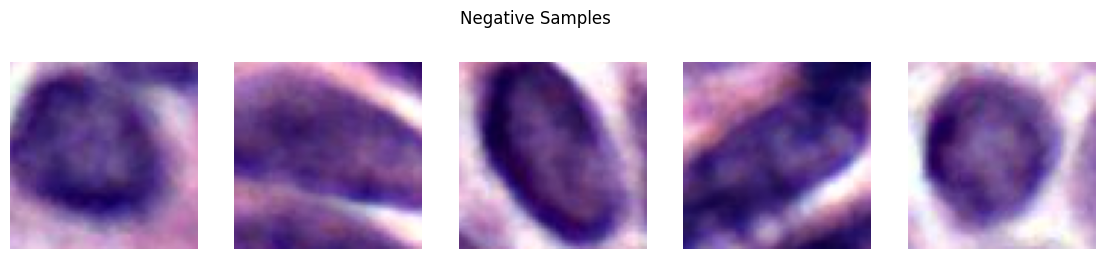

In [9]:
data_dir = "./liu-test-set/"
transform = get_transform(normalize=False)
dataset = AdaptivePatchDataset(data_dir, transform=transform, max_size=32)
positive_samples = [sample[0] for sample in dataset.samples if sample[1] == 1][:5]
negative_samples = [sample[0] for sample in dataset.samples if sample[1] == 0][:5]
def show_samples(image_paths, title):
    plt.figure(figsize=(14, 3))
    for i, img_path in enumerate(image_paths):
        image = Image.open(img_path)
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(title)
show_samples(positive_samples, "Positive Samples")
show_samples(negative_samples, "Negative Samples")

## Model Architecture and Initialization

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out
class NucleiClassifier(nn.Module):
    def __init__(self, input_size=32, base_channels=64):
        super(NucleiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(base_channels, base_channels, 2)
        self.layer2 = self.make_layer(base_channels, base_channels*2, 2, stride=2)
        self.layer3 = self.make_layer(base_channels*2, base_channels*4, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(base_channels*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
def load_model(model_path, device):
    model = NucleiClassifier()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

## Model Evaluation Framework

In [11]:
def evaluate_model(model, data_loader, device):
    model.to(device)
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels
            outputs = model(images).squeeze()
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)
    return all_preds, all_labels, all_probs
def create_visualizations(preds, labels, probs):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(labels, preds)
    print(classification_report(labels, preds))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    return roc_auc

## Performance Assessment

Evaluating: 100%|███████████████████████████████████████████████████████████| 72/72 [00:06<00:00, 11.99it/s]

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1208
           1       0.88      0.95      0.91      1084

    accuracy                           0.92      2292
   macro avg       0.92      0.92      0.92      2292
weighted avg       0.92      0.92      0.92      2292



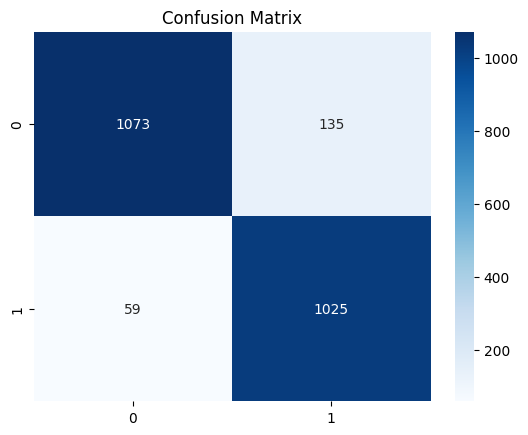

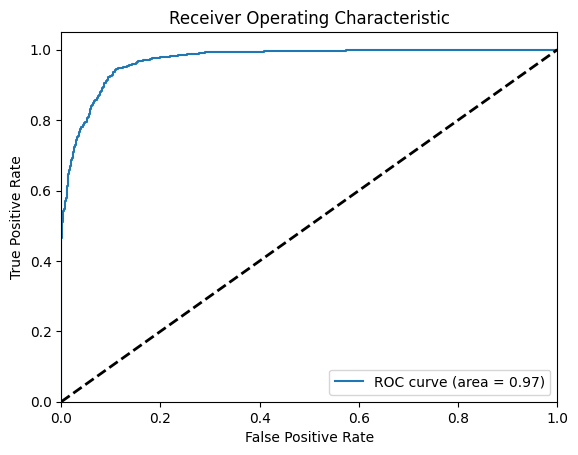

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model_path = "./best_model.pth"
model = load_model(model_path, device)

# Load data
batch_size = 32
data_loader = get_data_loader(data_dir, batch_size=batch_size, transform=get_transform(), max_size=32)

# Evaluate model
preds, labels, probs = evaluate_model(model, data_loader, device)

# Create visualizations
roc_auc = create_visualizations(preds, labels, probs)

# Display ROC-AUC curve
fpr, tpr, _ = roc_curve(labels, probs)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()